# Segmenting and describing regions

This part of the course is about separating specific regions of interest in a image from the background automatically, and extracting descriptors from them for downstream analysis.

Run the code making sure you understand the syntax. Complete the parts marked **TODO** either in the text or in the code.

## Setup

First, we need to import some packages so that their functions are available to us.

In [2]:
import os                       # operating system operations like file paths etc
import numpy as np              # multidimensional arrays, linear algebra
from skimage import morphology  # morphological operations
from skimage import io          # to load and save data
from skimage import color       # color conversion utilities
from skimage.util import invert   # invert an image (if binary, black->white, white->black)
from skimage import img_as_ubyte # Convert an image to 8-bits
from skimage.filters import threshold_otsu # Otsu's thresholding method

import matplotlib.pyplot as plt # plotting
from matplotlib.ticker import MaxNLocator


path_to_images= './data'    # Local: where the images are relative to this notebook
#path_to_images= os.path.join('Module2','data')    # Nuvolos: where the images are relative to this notebook

## Segmentation

### Threshold-based approaches

#### Basline - Otsu

Image has shape (512, 640)
Found 15 connected components


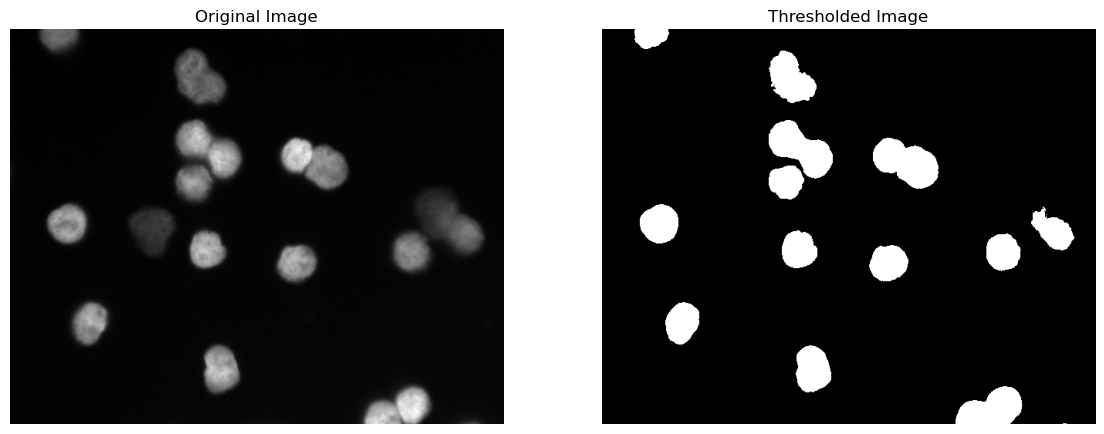

In [3]:
from skimage.filters import threshold_otsu

# Load and normalize the neuroblastoma image
image_file = os.path.join(path_to_images, 'neuroblastoma_5_orig_small.jpg')
img = io.imread(image_file)
img = img/np.max(img) # normalize the image to [0,1]
print(f'Image has shape {img.shape}')

# threshold the image with Otsu's method
thresh = threshold_otsu(img)
binary_img = img > thresh

# look for connected components to count cells
labeled_img, num_labels = morphology.label(binary_img, background=0, return_num=True, connectivity=1)
print(f'Found {num_labels} connected components')


# Display the original image, the Sobel the detected edges side by side
fig, axes = plt.subplots(1, 2, figsize=(14, 7))
axes[0].imshow(img, cmap='gray')
axes[0].set_title('Original Image')
axes[0].axis('off')
axes[1].imshow(binary_img, cmap='gray')
axes[1].set_title('Thresholded Image')
axes[1].axis('off')

plt.show()

### Watershed

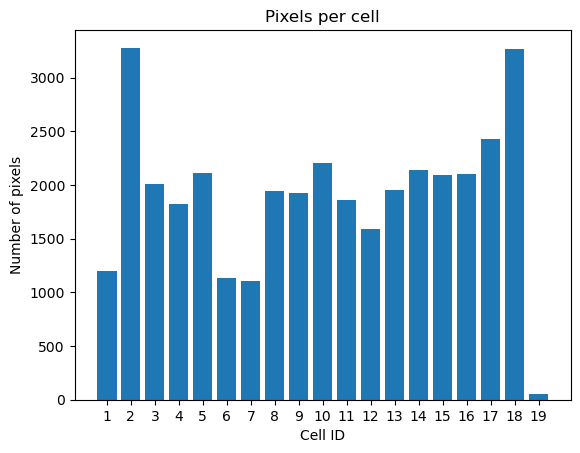

Found 24 local maxima
Local maxima image has 24 marked points
Markers image has 19 markers
Cell labels: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19]
Watershed algorithm found 19 unique labels


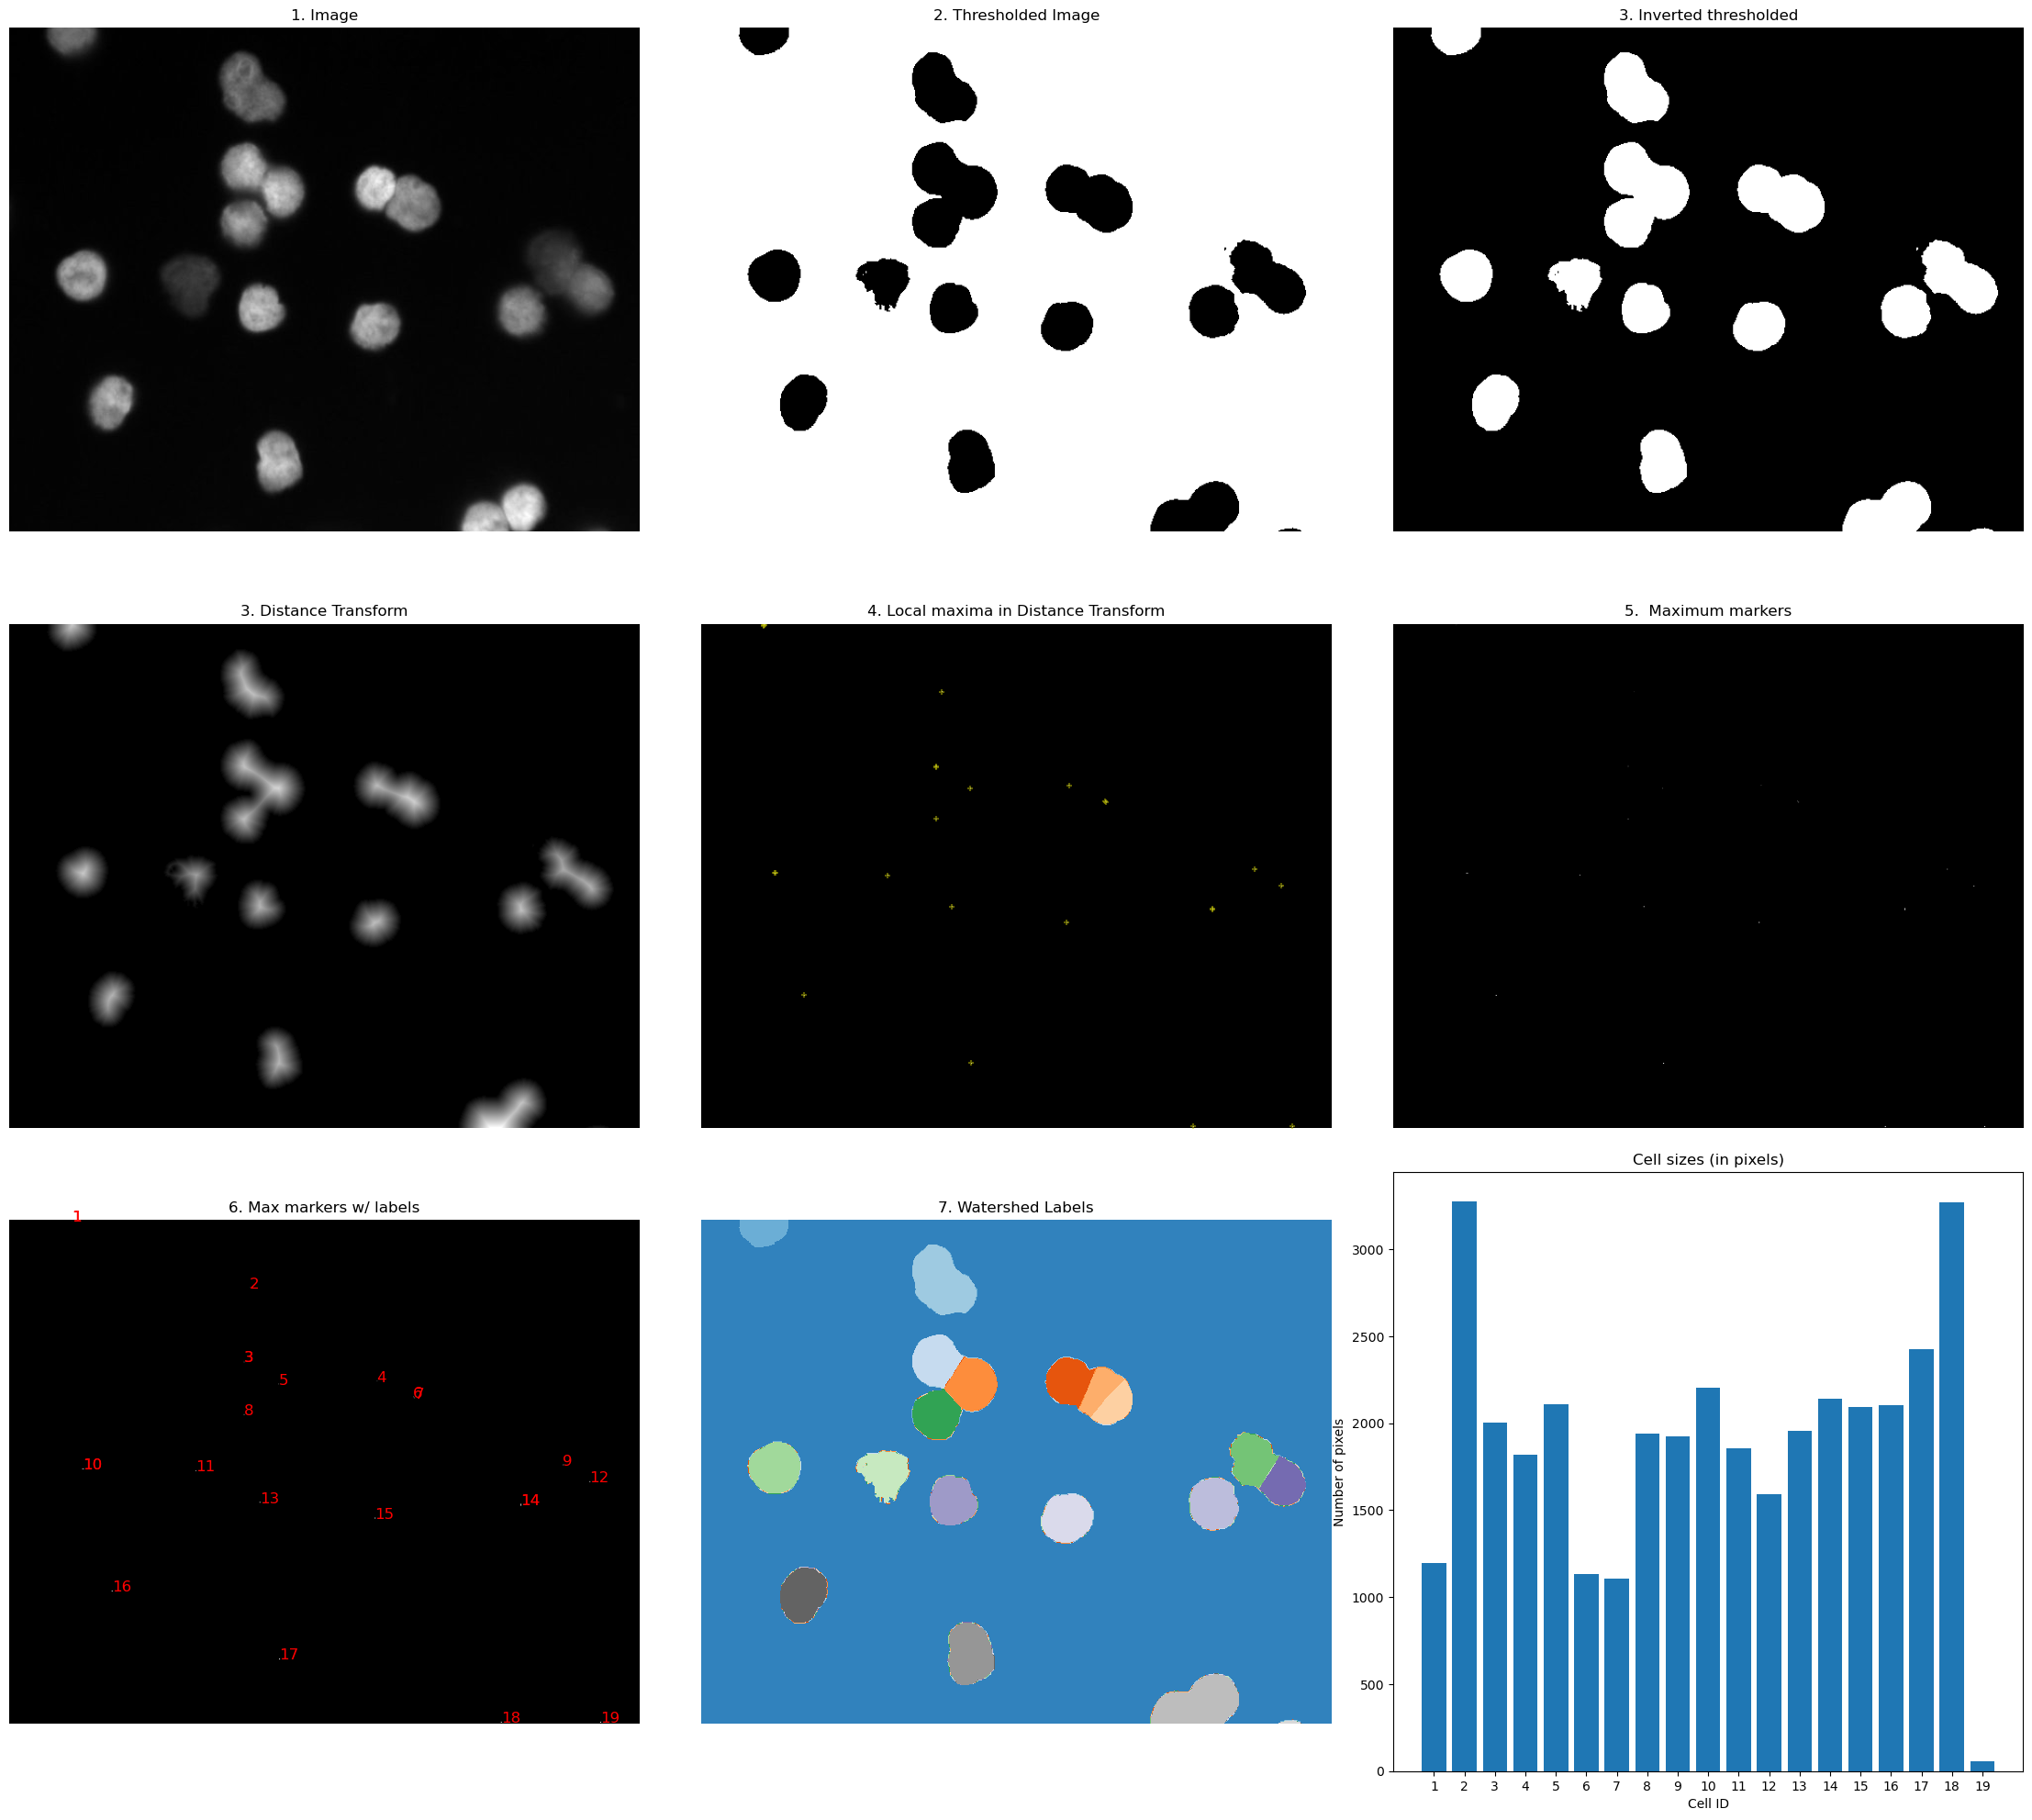

In [59]:
# WATERSHED SEGMENTATION
from scipy import ndimage as ndi
from skimage.feature import peak_local_max
from skimage.segmentation import watershed

# Load and normalize the neuroblastoma image
image_file = os.path.join(path_to_images, 'neuroblastoma_5_orig_small.jpg')
img = io.imread(image_file)
img = img/np.max(img) # normalize the image to [0,1]

# Binarize by thresholding, then invert
img_bin=img < 0.2
img_bin_inv = invert(img_bin)

# compute distance transform - shortest distance from this pixel to the background
img_dist = ndi.distance_transform_edt(img_bin_inv)

# find coordinates of local maxima in distance transform image
coords_max = peak_local_max(img_dist, footprint=np.ones((25,25)), labels=img_bin_inv)
print(f'Found {coords_max.shape[0]} local maxima')

# create an image with these coordinates marked as True
local_maxima = np.zeros(img_dist.shape, dtype=bool)
local_maxima[tuple(coords_max.T)] = True
print(f'Local maxima image has {np.sum(local_maxima.ravel())} marked points')

# now create markers for the watershed algorithm, use one-connected neighbourhoods to define whether
# two local maxima should be merged
markers, _ = ndi.label(local_maxima)
print(f'Markers image has {len(np.unique(markers))-1} markers') # -1 because 0 is background
print(f'Cell labels: {np.unique(markers)}')
import matplotlib.pyplot as plt

# Run watershed algorithm to label each pixel with the marker of the local maximum it is closest to
labels = watershed(img_dist, markers, mask=img_bin_inv,compactness=1)
print(f'Watershed algorithm found {len(np.unique(labels))-1} unique labels') # -1 because 0 is background

# Show all processing steps in Watershed segmentation
fig, axes = plt.subplots(3, 3, figsize=(22, 20))
axes[0,0].imshow(img, cmap='gray')
axes[0,0].set_title('1. Image')
axes[0,0].axis('off')
axes[0,1].imshow(img_bin, cmap='gray')
axes[0,1].set_title('2. Thresholded Image')
axes[0,1].axis('off')
axes[0,2].imshow(img_bin_inv, cmap='gray')
axes[0,2].set_title('3. Inverted thresholded')
axes[0,2].axis('off')

axes[1,0].imshow(img_dist, cmap='gray')
axes[1,0].set_title('3. Distance Transform')
axes[1,0].axis('off')
axes[1,1].imshow(local_maxima, cmap='gray')
axes[1,1].set_title('4. Local maxima in Distance Transform')
axes[1,1].axis('off')
axes[1,1].scatter(coords_max[:,1], coords_max[:,0], c='y', s=20, marker="+", alpha=0.5)
axes[1,2].imshow(markers, cmap='gray')
axes[1,2].set_title('5.  Maximum markers')
axes[1,2].axis('off')

# Find non-zero pixels in the markers image
non_zero_pixels = markers[markers != 0]
# Plot a string equal to the value of the non-zero pixel at that location in the image
axes[2,0].imshow(markers, cmap='gray')
for i, pixel in enumerate(non_zero_pixels):
    row, col = np.where(markers == pixel)
    axes[2,0].text(col[0], row[0], str(pixel), color='red', fontsize=12)
axes[2,0].set_title('6. Max markers w/ labels')
axes[2,0].axis('off')

axes[2,1].imshow(labels, cmap='tab20c')
axes[2,1].set_title('7. Watershed Labels')
axes[2,1].axis('off')

unique_labels, label_counts = np.unique(labels[labels>0].ravel(), return_counts=True)
axes[2,2].bar(unique_labels, label_counts, align='center')
axes[2,2].set_xticks(unique_labels)
axes[2,2].set_title('Cell sizes (in pixels)')
axes[2,2].set_xlabel('Cell ID')
axes[2,2].set_ylabel('Number of pixels')


plt.tight_layout(pad=0.3)







As you can see this algorithm has many steps, in addition to the usual preprocessing steps such as normalizing, thresholding etc.

Let's examine one by one the effect of the steps.

**TODO** What is the effect of the size structuring element ("footprint" in skimage lingo) used to detect local maxima of the distance function? Try modifying it. Do you get fewer, more, or the same number of local maxima? Why does this happen? 

**TODO** What is the effect of the compactness parameter in the Watershed algorithm?

## Description

We already have our very first region descriptor just from counting pixels - region size! in many applications such as flow cytometry, cell size is an important parameter. but we can do much more.

